In [ ]:
import os, random, copy, itertools
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc)

#  Reproducibility 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#  Paths & Config 
ROOT = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"  
SAVE_DIR = "C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl"
os.makedirs(SAVE_DIR, exist_ok=True)

IMAGE_SIZE = 224
BYOL_BS = 64
BYOL_EPOCHS = 50
FINETUNE_EPOCHS = 50
FINETUNE_BS = 32
PROJ_DIM = 128
FINETUNE_LR = 5e-5


Device: cuda


In [2]:
import os

data_dir = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"
classes = os.listdir(data_dir)
for cls in classes:
    print(f"Class: {cls}, Number of Images: {len(os.listdir(os.path.join(data_dir, cls)))}")

Class: 1Gallstones, Number of Images: 1326
Class: 2Abdomen and retroperitoneum, Number of Images: 1170
Class: 3cholecystitis, Number of Images: 1146
Class: 4Membranous and gangrenous cholecystitis, Number of Images: 1224
Class: 5Perforation, Number of Images: 1062
Class: 6Polyps and cholesterol crystals, Number of Images: 1020
Class: 7Adenomyomatosis, Number of Images: 1164
Class: 8Carcinoma, Number of Images: 1590
Class: 9Various causes of gallbladder wall thickening, Number of Images: 990


In [3]:
from PIL import Image

image_sizes = []
for cls in classes:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        img = Image.open(os.path.join(data_dir, cls, img_file))
        image_sizes.append(img.size)

print(set(image_sizes))  # Unique image sizes

{(2400, 1800), (1170, 876), (900, 1200), (1200, 900)}


In [4]:
corrupted_images = []
for cls in classes:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        try:
            img = Image.open(os.path.join(data_dir, cls, img_file))
            img.verify()  # Check for corruption
        except (IOError, SyntaxError):
            corrupted_images.append(img_file)

print("Corrupted Images:", corrupted_images)

Corrupted Images: []


C:\Users\MSC055\AppData\Local\Temp\ipykernel_19372\4129037397.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=class_counts, palette = 'Set1', lw = 1, edgecolor='black')


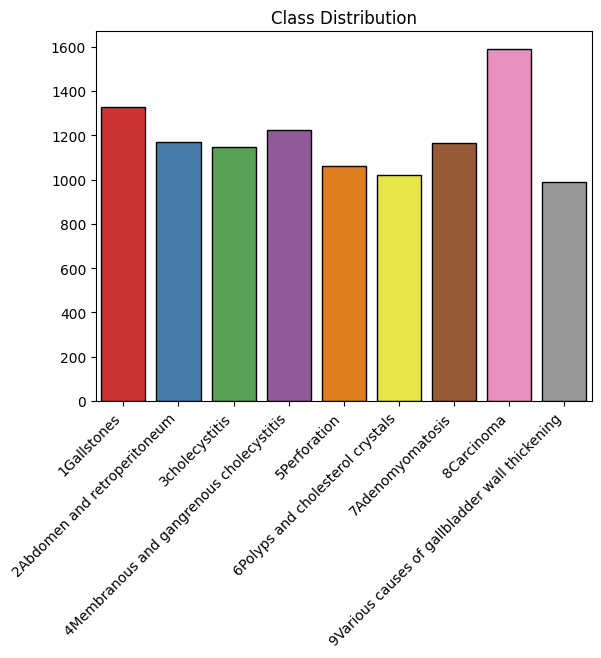

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]
sns.barplot(x=classes, y=class_counts, palette = 'Set1', lw = 1, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution")
plt.show()

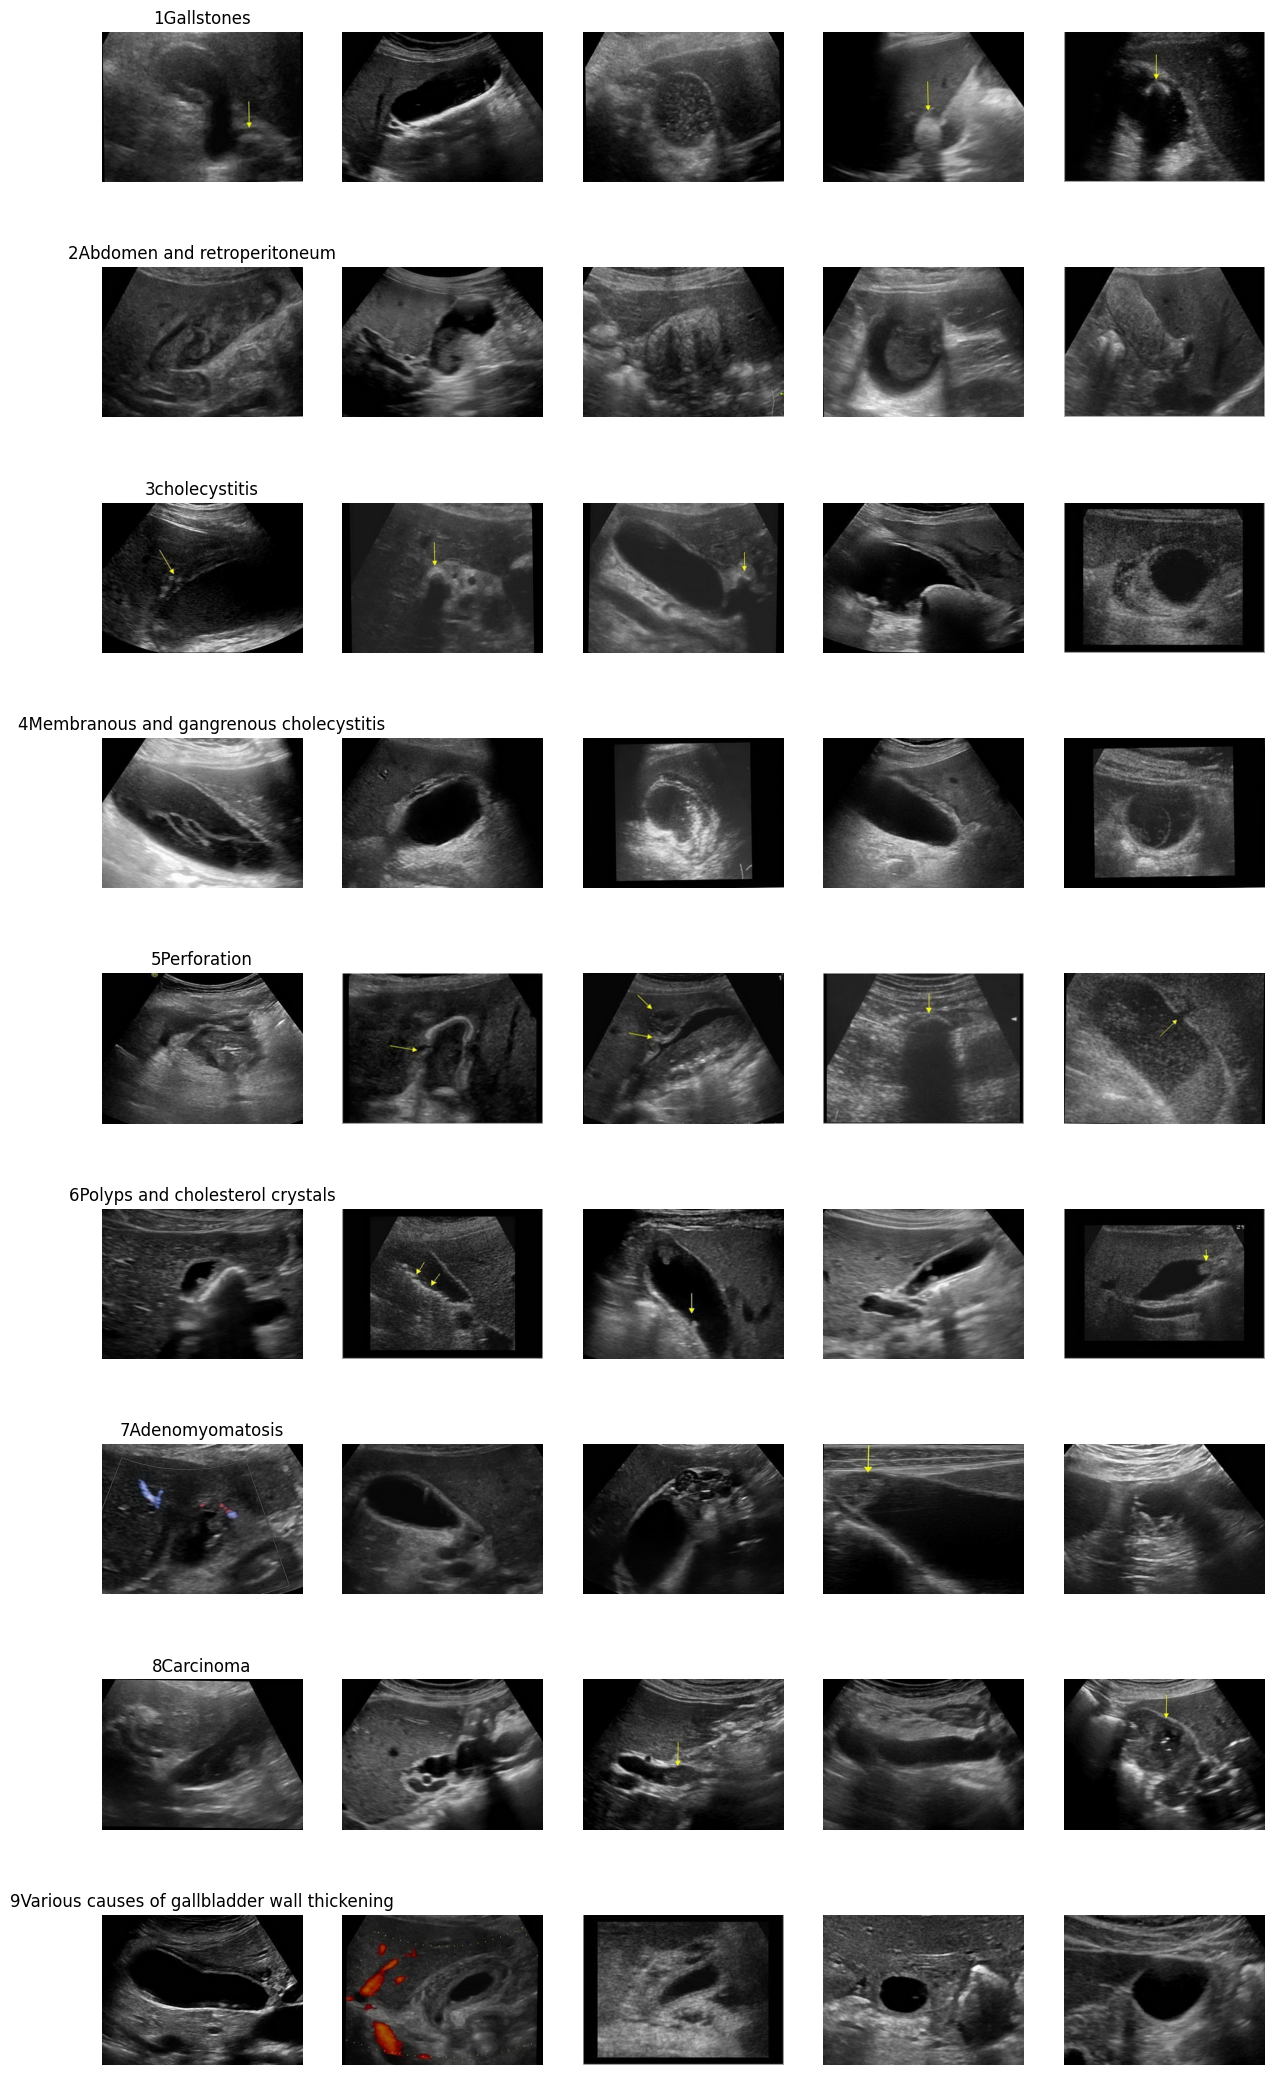

In [6]:
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(classes), 5, figsize=(15, len(classes) * 3))
for i, cls in enumerate(classes):
    class_dir = os.path.join(data_dir, cls)
    for j in range(5):
        img_path = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(cls)
plt.show()

In [7]:
root = Path(ROOT)
assert root.exists(), f"{ROOT} not found"

# Collect image paths & labels
image_paths = []
image_labels = []
class_names = sorted([d.name for d in root.iterdir() if d.is_dir()])
class_to_idx = {c:i for i,c in enumerate(class_names)}

for cls in class_names:
    for p in (root / cls).glob("*"):
        if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
            image_paths.append(str(p))
            image_labels.append(class_to_idx[cls])

print("Classes:", class_names)
print("Total images:", len(image_paths))

# Stratified split
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, stratify=image_labels, random_state=SEED
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

idx_to_class = {v:k for k,v in class_to_idx.items()}
def print_class_counts(labels, name):
    counts = Counter(labels)
    print(f"\n{name} class distribution:")
    for cls_idx, count in counts.items():
        print(f"  {idx_to_class[cls_idx]} ({cls_idx}): {count}")
    print("Total:", sum(counts.values()))

print_class_counts(train_labels, "Train")
print_class_counts(val_labels, "Val")
print_class_counts(test_labels, "Test")


Classes: ['1Gallstones', '2Abdomen and retroperitoneum', '3cholecystitis', '4Membranous and gangrenous cholecystitis', '5Perforation', '6Polyps and cholesterol crystals', '7Adenomyomatosis', '8Carcinoma', '9Various causes of gallbladder wall thickening']
Total images: 10692
Train: 8553, Val: 1069, Test: 1070

Train class distribution:
  2Abdomen and retroperitoneum (1): 936
  7Adenomyomatosis (6): 931
  1Gallstones (0): 1061
  5Perforation (4): 849
  4Membranous and gangrenous cholecystitis (3): 979
  8Carcinoma (7): 1272
  6Polyps and cholesterol crystals (5): 816
  9Various causes of gallbladder wall thickening (8): 792
  3cholecystitis (2): 917
Total: 8553

Val class distribution:
  1Gallstones (0): 132
  8Carcinoma (7): 159
  3cholecystitis (2): 115
  7Adenomyomatosis (6): 116
  4Membranous and gangrenous cholecystitis (3): 122
  2Abdomen and retroperitoneum (1): 117
  6Polyps and cholesterol crystals (5): 102
  5Perforation (4): 107
  9Various causes of gallbladder wall thickening

In [8]:
# BYOL augmentations
byol_transforms = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=int(0.1*IMAGE_SIZE)//2*2+1, sigma=(0.1,2.0)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Fine-tune transforms
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Datasets
class BYOLDataset(Dataset):
    """Returns 2 augmented views"""
    def __init__(self, paths, transform):
        self.paths = list(paths)
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), self.transform(img)

class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Loaders
byol_dataset = BYOLDataset(train_paths, byol_transforms)
byol_loader = DataLoader(byol_dataset, batch_size=BYOL_BS, shuffle=True, drop_last=True)

ft_train_dataset = ImageDataset(train_paths, train_labels, train_transform)
ft_val_dataset = ImageDataset(val_paths, val_labels, eval_transform)
ft_test_dataset = ImageDataset(test_paths, test_labels, eval_transform)

train_loader = DataLoader(ft_train_dataset, batch_size=FINETUNE_BS, shuffle=True)
val_loader = DataLoader(ft_val_dataset, batch_size=FINETUNE_BS, shuffle=False)
test_loader = DataLoader(ft_test_dataset, batch_size=FINETUNE_BS, shuffle=False)


In [9]:
class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        res = models.resnet50(pretrained=pretrained)
        self.features = nn.Sequential(*list(res.children())[:-1])  # exclude fc
        self.out_dim = 2048
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        return x

# BYOL model
class MLPHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=2048, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class BYOLModel(nn.Module):
    def __init__(self, base_encoder, proj_dim=128):
        super().__init__()
        self.encoder = base_encoder
        feat_dim = self.encoder.out_dim
        self.projector = MLPHead(feat_dim, hidden_dim=2048, out_dim=proj_dim)
        self.predictor = MLPHead(proj_dim, hidden_dim=512, out_dim=proj_dim)
    def forward(self, x):
        h = self.encoder(x)
        z = F.normalize(self.projector(h),dim=1)
        p = F.normalize(self.predictor(z),dim=1)
        return h, z, p
    @torch.no_grad()
    def forward_projection(self, x):
        h = self.encoder(x)
        z = F.normalize(self.projector(h),dim=1)
        return z


In [10]:
base_enc = ResNet50Encoder(pretrained=False)
online = BYOLModel(base_enc, proj_dim=128).to(device)
target = copy.deepcopy(online).to(device)
target.eval()
for p in target.parameters():
    p.requires_grad = False


c:\Users\MSC055\.conda\envs\pytorch2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MSC055\.conda\envs\pytorch2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
def byol_loss(p, z):
    return 2 - 2*(p*z).sum(dim=1).mean()

def update_target(online, target, beta=0.996):
    for online_p, target_p in zip(online.parameters(), target.parameters()):
        target_p.data = beta*target_p.data + (1-beta)*online_p.data


BYOL Epoch 1/50: 100%|██████████| 133/133 [03:39<00:00,  1.65s/it]


BYOL Epoch 1 completed. Symmetrized Negative Cosine Similarit Loss: 0.134983


BYOL Epoch 2/50: 100%|██████████| 133/133 [03:53<00:00,  1.76s/it]


BYOL Epoch 2 completed. Symmetrized Negative Cosine Similarit Loss: 0.008773


BYOL Epoch 3/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 3 completed. Symmetrized Negative Cosine Similarit Loss: 0.002982


BYOL Epoch 4/50: 100%|██████████| 133/133 [03:53<00:00,  1.76s/it]


BYOL Epoch 4 completed. Symmetrized Negative Cosine Similarit Loss: 0.000962


BYOL Epoch 5/50: 100%|██████████| 133/133 [03:53<00:00,  1.75s/it]


BYOL Epoch 5 completed. Symmetrized Negative Cosine Similarit Loss: 0.000402


BYOL Epoch 6/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 6 completed. Symmetrized Negative Cosine Similarit Loss: 0.000236


BYOL Epoch 7/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 7 completed. Symmetrized Negative Cosine Similarit Loss: 0.000133


BYOL Epoch 8/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 8 completed. Symmetrized Negative Cosine Similarit Loss: 0.000079


BYOL Epoch 9/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 9 completed. Symmetrized Negative Cosine Similarit Loss: 0.000060


BYOL Epoch 10/50: 100%|██████████| 133/133 [03:53<00:00,  1.75s/it]


BYOL Epoch 10 completed. Symmetrized Negative Cosine Similarit Loss: 0.000034


BYOL Epoch 11/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 11 completed. Symmetrized Negative Cosine Similarit Loss: 0.000035


BYOL Epoch 12/50: 100%|██████████| 133/133 [03:57<00:00,  1.79s/it]


BYOL Epoch 12 completed. Symmetrized Negative Cosine Similarit Loss: 0.000026


BYOL Epoch 13/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 13 completed. Symmetrized Negative Cosine Similarit Loss: 0.000022


BYOL Epoch 14/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 14 completed. Symmetrized Negative Cosine Similarit Loss: 0.000012


BYOL Epoch 15/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 15 completed. Symmetrized Negative Cosine Similarit Loss: 0.000009


BYOL Epoch 16/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 16 completed. Symmetrized Negative Cosine Similarit Loss: 0.000010


BYOL Epoch 17/50: 100%|██████████| 133/133 [03:53<00:00,  1.76s/it]


BYOL Epoch 17 completed. Symmetrized Negative Cosine Similarit Loss: 0.000011


BYOL Epoch 18/50: 100%|██████████| 133/133 [03:50<00:00,  1.74s/it]


BYOL Epoch 18 completed. Symmetrized Negative Cosine Similarit Loss: 0.000014


BYOL Epoch 19/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 19 completed. Symmetrized Negative Cosine Similarit Loss: 0.000034


BYOL Epoch 20/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 20 completed. Symmetrized Negative Cosine Similarit Loss: 0.000011


BYOL Epoch 21/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 21 completed. Symmetrized Negative Cosine Similarit Loss: 0.000006


BYOL Epoch 22/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 22 completed. Symmetrized Negative Cosine Similarit Loss: 0.000004


BYOL Epoch 23/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 23 completed. Symmetrized Negative Cosine Similarit Loss: 0.000005


BYOL Epoch 24/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 24 completed. Symmetrized Negative Cosine Similarit Loss: 0.000004


BYOL Epoch 25/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 25 completed. Symmetrized Negative Cosine Similarit Loss: 0.000007


BYOL Epoch 26/50: 100%|██████████| 133/133 [03:50<00:00,  1.74s/it]


BYOL Epoch 26 completed. Symmetrized Negative Cosine Similarit Loss: 0.000004


BYOL Epoch 27/50: 100%|██████████| 133/133 [03:57<00:00,  1.79s/it]


BYOL Epoch 27 completed. Symmetrized Negative Cosine Similarit Loss: 0.000003


BYOL Epoch 28/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 28 completed. Symmetrized Negative Cosine Similarit Loss: 0.000003


BYOL Epoch 29/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 29 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 30/50: 100%|██████████| 133/133 [03:53<00:00,  1.75s/it]


BYOL Epoch 30 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 31/50: 100%|██████████| 133/133 [03:53<00:00,  1.75s/it]


BYOL Epoch 31 completed. Symmetrized Negative Cosine Similarit Loss: 0.000004


BYOL Epoch 32/50: 100%|██████████| 133/133 [03:55<00:00,  1.77s/it]


BYOL Epoch 32 completed. Symmetrized Negative Cosine Similarit Loss: 0.000004


BYOL Epoch 33/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 33 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 34/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 34 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 35/50: 100%|██████████| 133/133 [03:50<00:00,  1.74s/it]


BYOL Epoch 35 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 36/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 36 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 37/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 37 completed. Symmetrized Negative Cosine Similarit Loss: 0.000004


BYOL Epoch 38/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 38 completed. Symmetrized Negative Cosine Similarit Loss: 0.000051


BYOL Epoch 39/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 39 completed. Symmetrized Negative Cosine Similarit Loss: 0.000010


BYOL Epoch 40/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 40 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 41/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 41 completed. Symmetrized Negative Cosine Similarit Loss: 0.000002


BYOL Epoch 42/50: 100%|██████████| 133/133 [03:56<00:00,  1.78s/it]


BYOL Epoch 42 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 43/50: 100%|██████████| 133/133 [03:54<00:00,  1.76s/it]


BYOL Epoch 43 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 44/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 44 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 45/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 45 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 46/50: 100%|██████████| 133/133 [03:53<00:00,  1.76s/it]


BYOL Epoch 46 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 47/50: 100%|██████████| 133/133 [03:50<00:00,  1.74s/it]


BYOL Epoch 47 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 48/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 48 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 49/50: 100%|██████████| 133/133 [03:52<00:00,  1.75s/it]


BYOL Epoch 49 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001


BYOL Epoch 50/50: 100%|██████████| 133/133 [03:51<00:00,  1.74s/it]


BYOL Epoch 50 completed. Symmetrized Negative Cosine Similarit Loss: 0.000001
BYOL weights saved to: C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\byol_pretrain_weights.pth


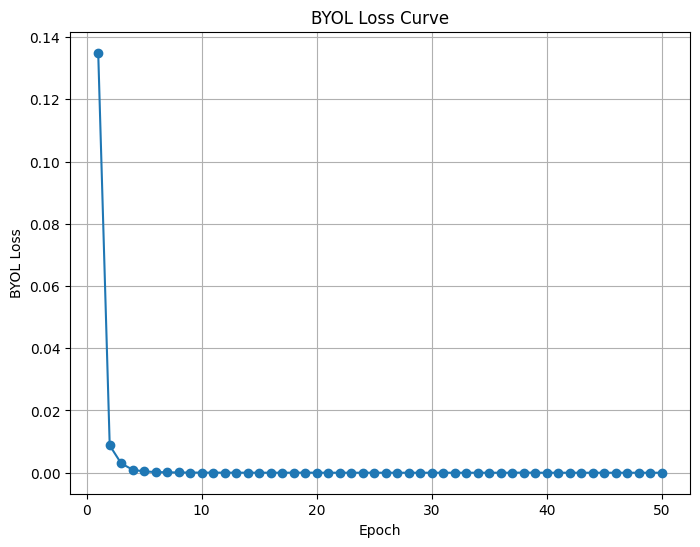

In [ ]:
optimizer = torch.optim.AdamW(online.parameters(), lr=1e-3, weight_decay=1e-6)
byol_losses = []

for epoch in range(1,BYOL_EPOCHS+1):
    online.train()
    running_loss = 0.0
    for x1,x2 in tqdm(byol_loader, desc=f"BYOL Epoch {epoch}/{BYOL_EPOCHS}"):
        x1,x2 = x1.to(device), x2.to(device)
        optimizer.zero_grad()
        _, _, p1 = online(x1)
        _, _, p2 = online(x2)
        with torch.no_grad():
            z1 = target.forward_projection(x1)
            z2 = target.forward_projection(x2)
        loss = byol_loss(p1,z2)+byol_loss(p2,z1)
        loss.backward(); optimizer.step()
        update_target(online,target,beta=0.996)
        running_loss += loss.item()
    epoch_loss = running_loss / len(byol_loader)
    byol_losses.append(epoch_loss)
    print(f"BYOL Epoch {epoch} completed. Symmetrized Negative Cosine Similarit Loss: {epoch_loss:.6f}")

    byol_pretrain_weights_path = os.path.join(SAVE_DIR, "byol_pretrain_weights.pth")
    torch.save({'epoch':epoch,
                'online_state_dict':online.state_dict(),
                'optimizer':optimizer.state_dict()
                }, byol_pretrain_weights_path)
print(f"BYOL weights saved to: {byol_pretrain_weights_path}")          

plt.figure(figsize=(8,6))
plt.plot(range(1,BYOL_EPOCHS+1),byol_losses,marker='o')
plt.xlabel("Epoch")
plt.ylabel("BYOL Loss")
plt.title("BYOL Loss Curve")
plt.grid(True)
plt.show()


In [13]:
class FineTuneResNet50(nn.Module):
    def __init__(self, byol_model, num_classes):
        super().__init__()
        self.backbone = byol_model.encoder
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.backbone.out_dim),
            nn.Linear(self.backbone.out_dim,self.backbone.out_dim//2),
            nn.ReLU(inplace=True),
            nn.Linear(self.backbone.out_dim//2,num_classes)
        )
    def forward(self,x):
        x = self.backbone(x)
        logits = self.classifier(x)
        return logits

num_classes = len(class_names)
finetune_model = FineTuneResNet50(online,num_classes).to(device)


In [14]:
optimizer_ft = torch.optim.AdamW([
    {'params': finetune_model.backbone.parameters(),'lr':FINETUNE_LR/5},
    {'params': finetune_model.classifier.parameters(),'lr':FINETUNE_LR}
],weight_decay=1e-4)
criterion_ft = nn.CrossEntropyLoss()

best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1,FINETUNE_EPOCHS+1):
    # train
    finetune_model.train()
    running_loss = running_corrects = total = 0
    for imgs,labels in tqdm(train_loader, desc=f"FT Train Epoch {epoch}/{FINETUNE_EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = finetune_model(imgs)
        loss = criterion_ft(outputs, labels)
        loss.backward(); optimizer_ft.step()
        preds = outputs.argmax(1)
        running_loss += loss.item()*imgs.size(0)
        running_corrects += (preds==labels).sum().item()
        total += imgs.size(0)
    train_losses.append(running_loss/total)
    train_accs.append(running_corrects/total)

    # val
    finetune_model.eval()
    running_loss = running_corrects = total = 0
    with torch.no_grad():
        for imgs,labels in val_loader:
            imgs,labels = imgs.to(device), labels.to(device)
            outputs = finetune_model(imgs)
            loss = criterion_ft(outputs, labels)
            preds = outputs.argmax(1)
            running_loss += loss.item()*imgs.size(0)
            running_corrects += (preds==labels).sum().item()
            total += imgs.size(0)
    val_losses.append(running_loss/total)
    val_accs.append(running_corrects/total)

    print(f"Epoch {epoch} | Train Loss {train_losses[-1]:.4f} | Train Acc {train_accs[-1]:.4f} | Val Loss {val_losses[-1]:.4f} | Val Acc {val_accs[-1]:.4f}")

    # save best
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        finetune_weights = os.path.join(SAVE_DIR, "finetune_best_resnet50.pth")
        torch.save({
            'epoch':epoch,
            'model_state_dict':finetune_model.state_dict(),
            'optimizer':optimizer_ft.state_dict(), 
            'val_acc':best_val_acc
        }, finetune_weights)
        print(f"  Saved best finetune model (val_acc={best_val_acc:.4f}) -> {finetune_weights}")


FT Train Epoch 1/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 1 | Train Loss 2.0829 | Train Acc 0.2191 | Val Loss 1.9764 | Val Acc 0.2675
  Saved best finetune model (val_acc=0.2675) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 2/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 2 | Train Loss 1.8539 | Train Acc 0.3291 | Val Loss 1.7709 | Val Acc 0.3686
  Saved best finetune model (val_acc=0.3686) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 3/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 3 | Train Loss 1.6686 | Train Acc 0.3925 | Val Loss 1.6124 | Val Acc 0.4443
  Saved best finetune model (val_acc=0.4443) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 4/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 4 | Train Loss 1.5019 | Train Acc 0.4644 | Val Loss 1.3977 | Val Acc 0.5285
  Saved best finetune model (val_acc=0.5285) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 5/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 5 | Train Loss 1.3627 | Train Acc 0.5141 | Val Loss 1.2792 | Val Acc 0.5482
  Saved best finetune model (val_acc=0.5482) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 6/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 6 | Train Loss 1.2016 | Train Acc 0.5764 | Val Loss 1.1153 | Val Acc 0.6211
  Saved best finetune model (val_acc=0.6211) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 7/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 7 | Train Loss 1.0741 | Train Acc 0.6249 | Val Loss 0.9653 | Val Acc 0.6595
  Saved best finetune model (val_acc=0.6595) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 8/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 8 | Train Loss 0.9301 | Train Acc 0.6815 | Val Loss 0.7962 | Val Acc 0.7540
  Saved best finetune model (val_acc=0.7540) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 9/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 9 | Train Loss 0.8154 | Train Acc 0.7216 | Val Loss 0.7337 | Val Acc 0.7615
  Saved best finetune model (val_acc=0.7615) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 10/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 10 | Train Loss 0.7268 | Train Acc 0.7490 | Val Loss 0.5796 | Val Acc 0.8157
  Saved best finetune model (val_acc=0.8157) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 11/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s]


Epoch 11 | Train Loss 0.6051 | Train Acc 0.8051 | Val Loss 0.4559 | Val Acc 0.8616
  Saved best finetune model (val_acc=0.8616) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 12/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 12 | Train Loss 0.5347 | Train Acc 0.8226 | Val Loss 0.3970 | Val Acc 0.8793
  Saved best finetune model (val_acc=0.8793) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 13/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 13 | Train Loss 0.4596 | Train Acc 0.8549 | Val Loss 0.3142 | Val Acc 0.9158
  Saved best finetune model (val_acc=0.9158) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 14/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 14 | Train Loss 0.4151 | Train Acc 0.8625 | Val Loss 0.2948 | Val Acc 0.9102


FT Train Epoch 15/50: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Epoch 15 | Train Loss 0.3524 | Train Acc 0.8880 | Val Loss 0.2702 | Val Acc 0.9289
  Saved best finetune model (val_acc=0.9289) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 16/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 16 | Train Loss 0.3225 | Train Acc 0.8920 | Val Loss 0.1822 | Val Acc 0.9579
  Saved best finetune model (val_acc=0.9579) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 17/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 17 | Train Loss 0.2737 | Train Acc 0.9170 | Val Loss 0.1554 | Val Acc 0.9542


FT Train Epoch 18/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 18 | Train Loss 0.2367 | Train Acc 0.9265 | Val Loss 0.1328 | Val Acc 0.9691
  Saved best finetune model (val_acc=0.9691) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 19/50: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s]


Epoch 19 | Train Loss 0.2279 | Train Acc 0.9251 | Val Loss 0.1208 | Val Acc 0.9710
  Saved best finetune model (val_acc=0.9710) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 20/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]


Epoch 20 | Train Loss 0.1865 | Train Acc 0.9396 | Val Loss 0.0856 | Val Acc 0.9775
  Saved best finetune model (val_acc=0.9775) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 21/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 21 | Train Loss 0.1840 | Train Acc 0.9429 | Val Loss 0.0901 | Val Acc 0.9785
  Saved best finetune model (val_acc=0.9785) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 22/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]


Epoch 22 | Train Loss 0.1725 | Train Acc 0.9421 | Val Loss 0.0985 | Val Acc 0.9841
  Saved best finetune model (val_acc=0.9841) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 23/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]


Epoch 23 | Train Loss 0.1523 | Train Acc 0.9532 | Val Loss 0.0471 | Val Acc 0.9906
  Saved best finetune model (val_acc=0.9906) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 24/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 24 | Train Loss 0.1254 | Train Acc 0.9626 | Val Loss 0.0519 | Val Acc 0.9869


FT Train Epoch 25/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 25 | Train Loss 0.1151 | Train Acc 0.9664 | Val Loss 0.0392 | Val Acc 0.9916
  Saved best finetune model (val_acc=0.9916) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 26/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 26 | Train Loss 0.1242 | Train Acc 0.9621 | Val Loss 0.0696 | Val Acc 0.9804


FT Train Epoch 27/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]


Epoch 27 | Train Loss 0.1074 | Train Acc 0.9648 | Val Loss 0.0379 | Val Acc 0.9944
  Saved best finetune model (val_acc=0.9944) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 28/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 28 | Train Loss 0.1044 | Train Acc 0.9678 | Val Loss 0.1260 | Val Acc 0.9673


FT Train Epoch 29/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 29 | Train Loss 0.1133 | Train Acc 0.9642 | Val Loss 0.0455 | Val Acc 0.9916


FT Train Epoch 30/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]


Epoch 30 | Train Loss 0.1035 | Train Acc 0.9685 | Val Loss 0.0241 | Val Acc 0.9972
  Saved best finetune model (val_acc=0.9972) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 31/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 31 | Train Loss 0.0868 | Train Acc 0.9731 | Val Loss 0.0190 | Val Acc 0.9953


FT Train Epoch 32/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s]


Epoch 32 | Train Loss 0.0772 | Train Acc 0.9773 | Val Loss 0.0333 | Val Acc 0.9935


FT Train Epoch 33/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s]


Epoch 33 | Train Loss 0.0729 | Train Acc 0.9765 | Val Loss 0.0157 | Val Acc 0.9981
  Saved best finetune model (val_acc=0.9981) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 34/50: 100%|██████████| 268/268 [01:18<00:00,  3.39it/s]


Epoch 34 | Train Loss 0.1031 | Train Acc 0.9670 | Val Loss 0.1027 | Val Acc 0.9813


FT Train Epoch 35/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 35 | Train Loss 0.0741 | Train Acc 0.9792 | Val Loss 0.0399 | Val Acc 0.9935


FT Train Epoch 36/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 36 | Train Loss 0.0598 | Train Acc 0.9819 | Val Loss 0.0143 | Val Acc 0.9963


FT Train Epoch 37/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 37 | Train Loss 0.0700 | Train Acc 0.9780 | Val Loss 0.0596 | Val Acc 0.9850


FT Train Epoch 38/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 38 | Train Loss 0.0761 | Train Acc 0.9751 | Val Loss 0.0164 | Val Acc 0.9963


FT Train Epoch 39/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 39 | Train Loss 0.0807 | Train Acc 0.9740 | Val Loss 0.0262 | Val Acc 0.9972


FT Train Epoch 40/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 40 | Train Loss 0.0558 | Train Acc 0.9827 | Val Loss 0.0333 | Val Acc 0.9972


FT Train Epoch 41/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 41 | Train Loss 0.0530 | Train Acc 0.9837 | Val Loss 0.0125 | Val Acc 0.9981


FT Train Epoch 42/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]


Epoch 42 | Train Loss 0.0519 | Train Acc 0.9839 | Val Loss 0.0069 | Val Acc 0.9981


FT Train Epoch 43/50: 100%|██████████| 268/268 [01:18<00:00,  3.42it/s]


Epoch 43 | Train Loss 0.0546 | Train Acc 0.9825 | Val Loss 0.0105 | Val Acc 0.9981


FT Train Epoch 44/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 44 | Train Loss 0.0507 | Train Acc 0.9842 | Val Loss 0.0190 | Val Acc 0.9991
  Saved best finetune model (val_acc=0.9991) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 45/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 45 | Train Loss 0.0778 | Train Acc 0.9759 | Val Loss 0.0243 | Val Acc 0.9944


FT Train Epoch 46/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 46 | Train Loss 0.0466 | Train Acc 0.9842 | Val Loss 0.0203 | Val Acc 0.9944


FT Train Epoch 47/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 47 | Train Loss 0.0423 | Train Acc 0.9856 | Val Loss 0.0034 | Val Acc 0.9991


FT Train Epoch 48/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s]


Epoch 48 | Train Loss 0.0487 | Train Acc 0.9840 | Val Loss 0.0095 | Val Acc 0.9991


FT Train Epoch 49/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Epoch 49 | Train Loss 0.0412 | Train Acc 0.9874 | Val Loss 0.0043 | Val Acc 1.0000
  Saved best finetune model (val_acc=1.0000) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_BYOL_ResNet50/outputs_byol_ssl\finetune_best_resnet50.pth


FT Train Epoch 50/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s]


Epoch 50 | Train Loss 0.0467 | Train Acc 0.9841 | Val Loss 0.2303 | Val Acc 0.9523


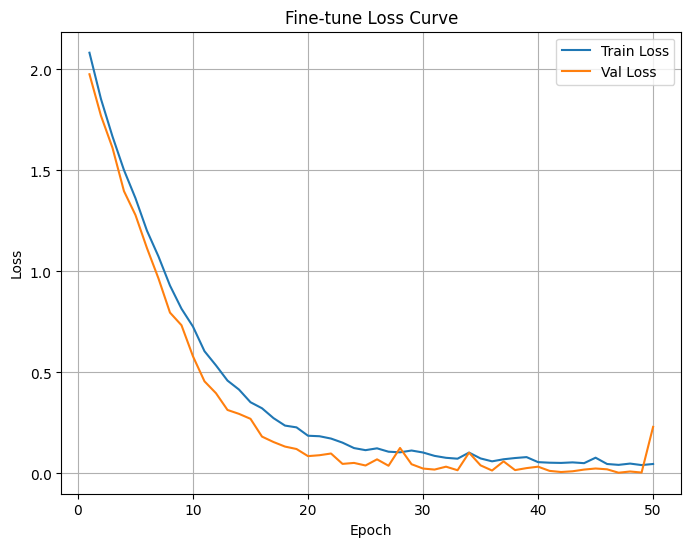

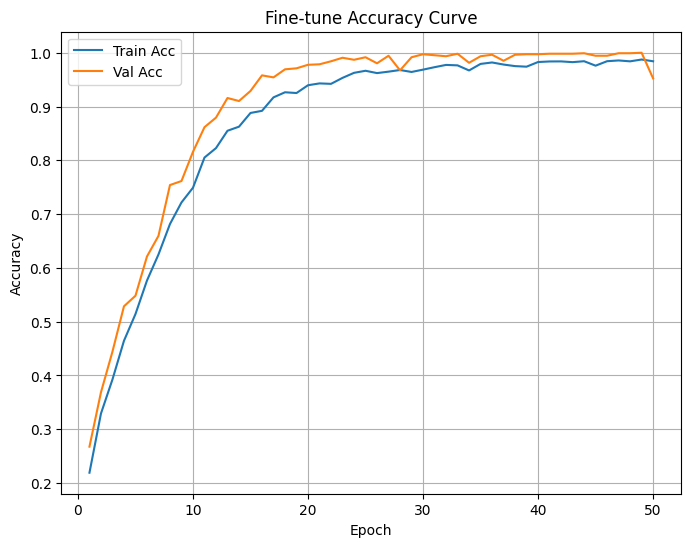

In [15]:
# Plot training curves
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.title("Fine-tune Loss Curve")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
plt.title("Fine-tune Accuracy Curve")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.show()


Evaluating on test set: 100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Test metrics:
  Accuracy:  0.9944
  Precision (macro): 0.9945
  Recall (macro):    0.9946
  F1 (macro):        0.9945

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       0.99      0.98      0.98       133
                  2Abdomen and retroperitoneum       0.99      1.00      1.00       117
                                3cholecystitis       1.00      0.97      0.99       114
      4Membranous and gangrenous cholecystitis       0.98      1.00      0.99       123
                                  5Perforation       1.00      1.00      1.00       106
              6Polyps and cholesterol crystals       1.00      1.00      1.00       102
                              7Adenomyomatosis       1.00      1.00      1.00       117
                                    8Carcinoma       1.00      1.00      1.00       159
9Various causes of gallbladder wall thickening       

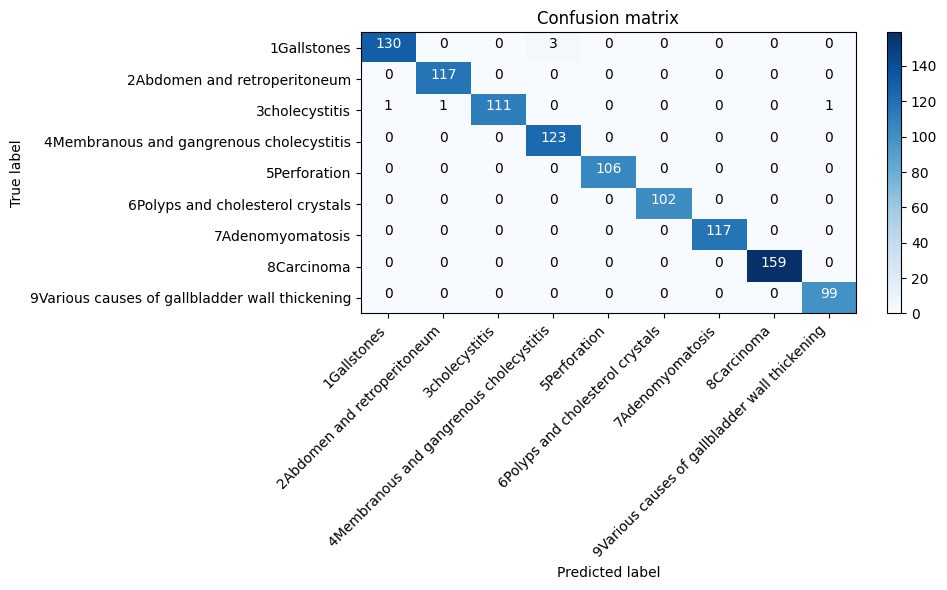

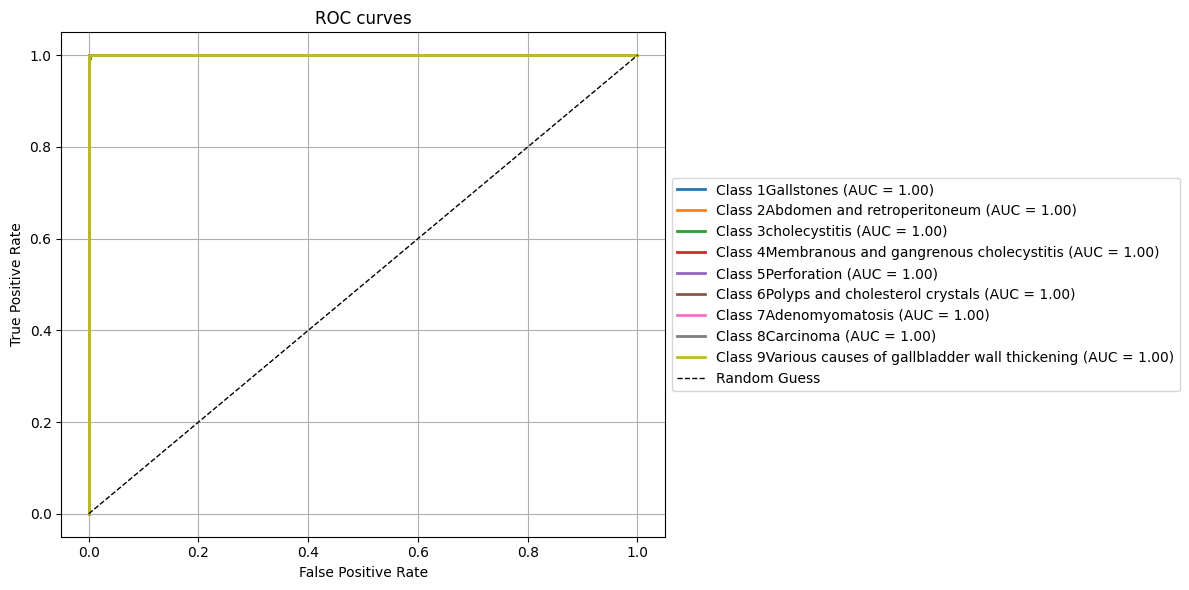

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_weights, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (macro): {precision_macro:.4f}")
print(f"  Recall (macro):    {recall_macro:.4f}")
print(f"  F1 (macro):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Evaluating on test set: 100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


Test metrics:
  Accuracy:  0.9944
  Precision (weighted): 0.9945
  Recall (weighted):    0.9944
  F1 (weighted):        0.9944

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       0.99      0.98      0.98       133
                  2Abdomen and retroperitoneum       0.99      1.00      1.00       117
                                3cholecystitis       1.00      0.97      0.99       114
      4Membranous and gangrenous cholecystitis       0.98      1.00      0.99       123
                                  5Perforation       1.00      1.00      1.00       106
              6Polyps and cholesterol crystals       1.00      1.00      1.00       102
                              7Adenomyomatosis       1.00      1.00      1.00       117
                                    8Carcinoma       1.00      1.00      1.00       159
9Various causes of gallbladder wall thickeni

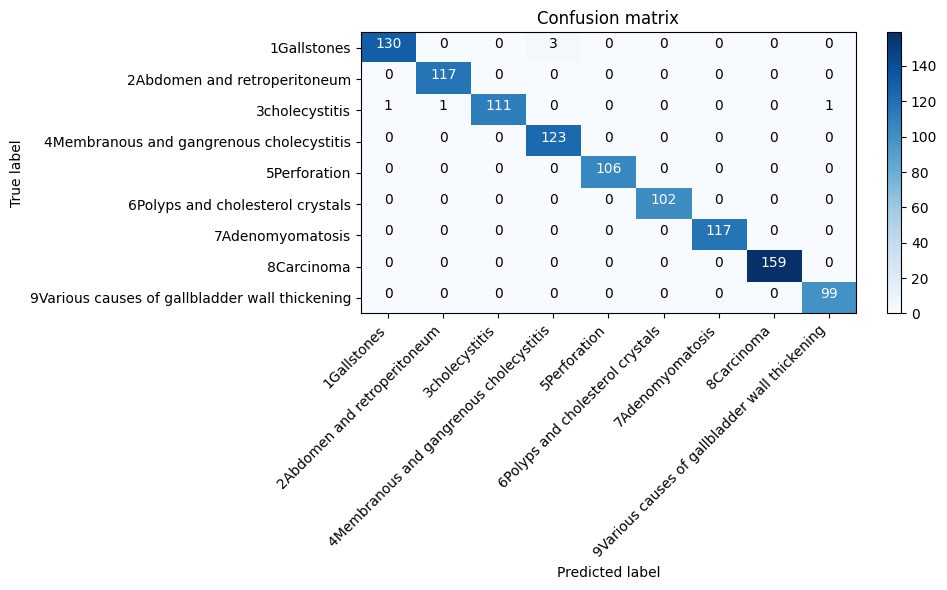

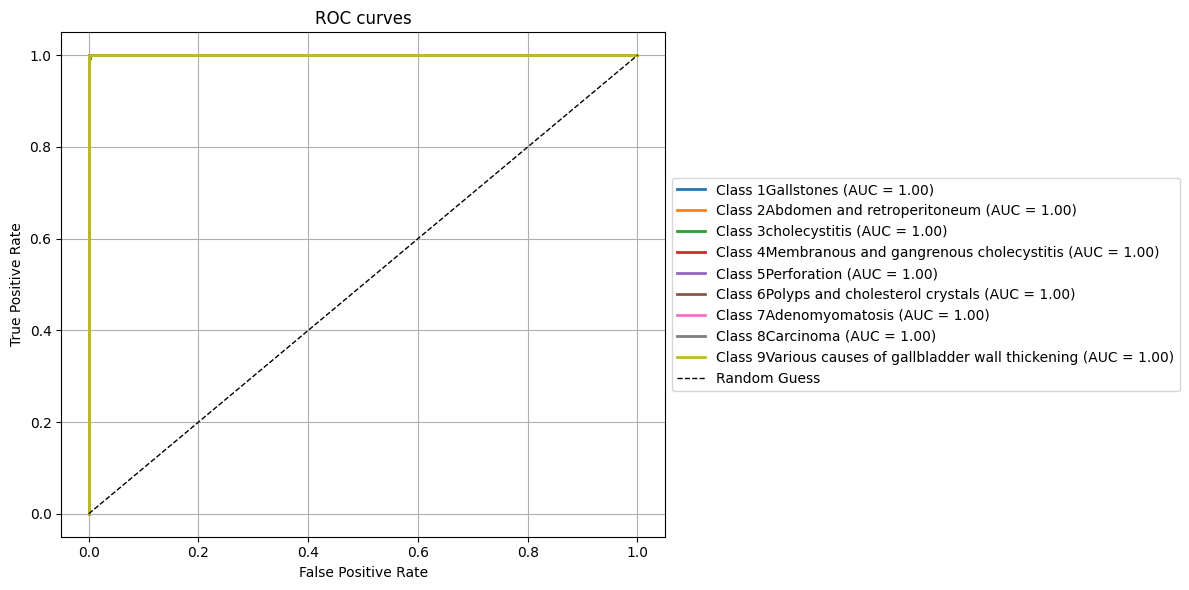

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_weights, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (weighted): {precision_macro:.4f}")
print(f"  Recall (weighted):    {recall_macro:.4f}")
print(f"  F1 (weighted):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 0.9774
  precision: 1.0000
  recall: 0.9774
  f1_score: 0.9886

Class: 2Abdomen and retroperitoneum
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 3cholecystitis
  accuracy: 0.9737
  precision: 1.0000
  recall: 0.9737
  f1_score: 0.9867

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 5Perforation
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 6Polyps and cholesterol crystals
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 7Adenomyomatosis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 8Carcinoma
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 9Various causes of gallbladder wall thickening
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from  test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 0.9774
  precision: 1.0000
  recall: 0.9774
  f1_score: 0.9886

Class: 2Abdomen and retroperitoneum
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 3cholecystitis
  accuracy: 0.9737
  precision: 1.0000
  recall: 0.9737
  f1_score: 0.9867

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 5Perforation
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 6Polyps and cholesterol crystals
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 7Adenomyomatosis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 8Carcinoma
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 9Various causes of gallbladder wall thickening
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

